In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import h5py 
import scipy
from PIL import Image
from scipy import ndimage

## Import Dataset

In [2]:
data_dict = pd.read_json("train.json")

In [3]:
data = []

# Loop through the elements in the annotations list
for annotation in data_dict['annotations']:
    # Get general bounding box information
    filename = annotation['filename']
    xmin = annotation['bndbox']['xmin']
    ymin = annotation['bndbox']['ymin']
    xmax = annotation['bndbox']['xmax']
    ymax = annotation['bndbox']['ymax']
    
    if annotation['inbox']:
        for inbox in annotation['inbox']:
            color = inbox['color']
            data.append({
                    'filename': filename,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax,
                    'color': color,
                })
    

# Create a DataFrame from a list of data and save it to a CSV file
df = pd.DataFrame(data)

In [4]:
df.head()

,filename,xmin,ymin,xmax,ymax,color
0,train_images\00001.jpg,1026.5,741.8,1077.5,910.9,red
1,train_images\00002.jpg,1418.7,1136.8,1428.3,1149.4,red
2,train_images\00003.jpg,2574.3,868.7,2632.3,887.1,red
3,train_images\00003.jpg,2252.1,899.6,2300.8,918.7,green
4,train_images\00004.jpg,833.3,1163.2,843.6,1184.8,green


In [5]:
cleaned_df = df[["filename", "color"]]

In [6]:
print(cleaned_df[cleaned_df['color']=='red'].shape)
print(cleaned_df[cleaned_df['color']=='green'].shape)

(5361, 2)
(3890, 2)


In [7]:
grouped = cleaned_df.groupby('filename')['color'].apply(list)

def determine_color(colors):
    if 'green' in colors:
        return 'green'
    elif 'yellow' in colors:
        return 'yellow'
    return 'red'

clean_colors_df = grouped.apply(determine_color)

result_df = clean_colors_df.reset_index()
result_df.columns = ['Filename', 'color']

In [8]:
grouped

filename
train_images\00001.jpg                                                [red]
train_images\00002.jpg                                                [red]
train_images\00003.jpg                                         [red, green]
train_images\00004.jpg                           [green, red, green, green]
train_images\00005.jpg                                       [green, green]
                                                ...                        
train_images\02996.jpg                [red, red, red, green, red, red, red]
train_images\02997.jpg                      [green, green, red, green, red]
train_images\02998.jpg                           [green, red, green, green]
train_images\02999.jpg    [green, green, green, green, green, red, green...
train_images\03000.jpg                    [red, green, green, green, green]
Name: color, Length: 2470, dtype: object

In [9]:
result_df.shape

(2470, 2)

In [10]:
result_df['color'].value_counts()

color
green     1680
red        703
yellow      87
Name: count, dtype: int64

In [11]:
df1 = result_df[(result_df['color'] == 'green') | (result_df['color'] == 'red')]

In [12]:
df1['label'] = np.where(df1['color'] == 'green', 1, 0)

/var/folders/d3/smnt9_0539z294w9kqbv59rh0000gn/T/ipykernel_52703/571686978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['label'] = np.where(df1['color'] == 'green', 1, 0)


In [13]:
df1["Filename"] = df1["Filename"].str.replace("\\", "/")

/var/folders/d3/smnt9_0539z294w9kqbv59rh0000gn/T/ipykernel_52703/1885997184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Filename"] = df1["Filename"].str.replace("\\", "/")


## Train Test Split

In [14]:
from sklearn.model_selection import train_test_split 
X = df1['Filename']
Y = df1['label']
X1, x_test, Y1, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8,random_state=42) 
x_train, x_cv, y_train, y_cv = train_test_split(X1,Y1,test_size = 0.25,train_size =0.75,random_state=42)

#X1 and Y1 are the features and targets for the training set
#x_test and y_test are the features and targets for the test set

#Overall Data Distribution
#Training Data: 60% of the original dataset (80% * 75%)
#Cross-Validation Data: 20% of the original dataset (80% * 25%)
#Testing Data: 20% of the original dataset (as directly specified in the first split)

In [15]:
x_test

506     train_images/00630.jpg
2467    train_images/02998.jpg
1770    train_images/02154.jpg
2079    train_images/02532.jpg
1716    train_images/02092.jpg
                 ...          
1500    train_images/01834.jpg
1041    train_images/01294.jpg
1018    train_images/01265.jpg
878     train_images/01100.jpg
285     train_images/00368.jpg
Name: Filename, Length: 477, dtype: object

In [16]:
y_test

506     1
2467    1
1770    1
2079    1
1716    1
       ..
1500    1
1041    1
1018    1
878     1
285     0
Name: label, Length: 477, dtype: int64

In [17]:
y_train.value_counts()

label
1    1006
0     423
Name: count, dtype: int64

In [18]:
print("label 0: ",len(y_test) - y_test.sum())
print("label 1: ", y_test.sum())

label 0:  141
label 1:  336


In [19]:
print("label 0: ",len(y_cv) - y_cv.sum())
print("label 1: ", y_cv.sum())

label 0:  139
label 1:  338


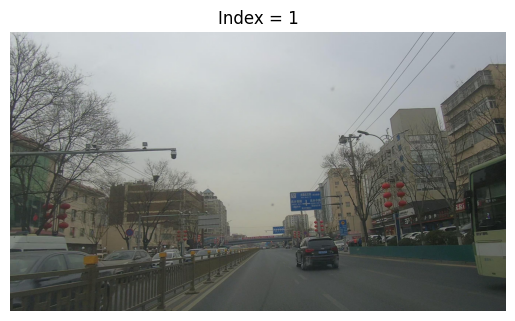

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
Index = 1
# Load the image file
image = Image.open(X[Index])

# Display the image
plt.imshow(image)
plt.title('Index = 1')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [21]:
import numpy as np
from PIL import Image

def load_images(image_paths, new_size=(128, 128)):
    images = []
    for path in image_paths:
        # Open the image file
        with Image.open(path) as img:
            # Resize the image
            img = img.resize(new_size)
            # Convert the image to a numpy array and normalize pixel values
            img_array = np.array(img) / 255.0
            images.append(img_array)
    return np.array(images)


## Load Images

In [22]:
# Example lists of image paths
train_image_paths = x_train
test_image_paths = x_test
cv_image_paths = x_cv

# Load images
X_train_image = load_images(train_image_paths)
x_test_image = load_images(test_image_paths)
x_cv_image = load_images(cv_image_paths)


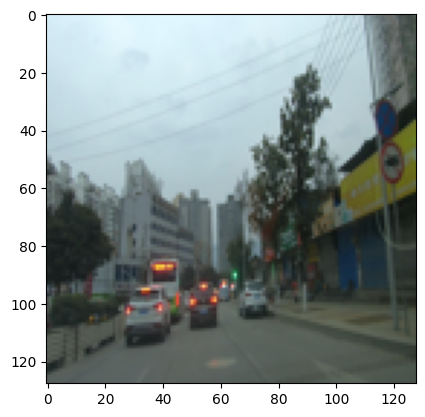

In [23]:
plt.imshow(X_train_image[0])

In [24]:
y_train = np.array(y_train)  # Assuming Y is already defined
y_test = np.array(y_test)
y_cv = np.array(y_cv)

Y_reshaped = y_train.reshape(1, -1)
y_test_reshaped = y_test.reshape(1,-1)
y_cv_reshaped = y_cv.reshape(1, -1)

print("New shape:", Y_reshaped.shape)
print("New shape:", y_test_reshaped.shape)
print("New shape:", y_cv_reshaped.shape)


New shape: (1, 1429)
New shape: (1, 477)
New shape: (1, 477)


In [25]:
# Find the values below:
m_train = X_train_image.shape[0]
m_test = x_test_image.shape[0]
m_cv = x_cv_image.shape[0]

num_px = X_train_image.shape[1]


print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Number of testing examples: m_cv = " + str(m_cv))

print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)") # 3 -> R, G, B
print ("train_set_x shape: " + str(X_train_image.shape)) 
print ("train_set_y shape: " + str(Y_reshaped.shape))
print ("test_set_x shape: " + str(x_test_image.shape)) 
print ("test_set_y shape: " + str(y_test_reshaped.shape))
print ("x_cv shape: " + str(x_cv_image.shape)) 
print ("y_cv shape: " + str(y_cv_reshaped.shape))

Number of training examples: m_train = 1429
Number of testing examples: m_test = 477
Number of testing examples: m_cv = 477
Height/Width of each image: num_px = 128
Each image is of size: (128, 128, 3)
train_set_x shape: (1429, 128, 128, 3)
train_set_y shape: (1, 1429)
test_set_x shape: (477, 128, 128, 3)
test_set_y shape: (1, 477)
x_cv shape: (477, 128, 128, 3)
y_cv shape: (1, 477)


## Reshaping Image

In [26]:
# Reshape the training and test examples
train_set_x = X_train_image.reshape(X_train_image.shape[0],-1).T # 64*64*3=12288
test_set_x = x_test_image.reshape(x_test_image.shape[0],-1).T
cv_set_x = x_cv_image.reshape(x_test_image.shape[0],-1).T


print ("train_set_x_flatten shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(Y_reshaped.shape))
print ("test_set_x_flatten shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(y_test_reshaped.shape))
print ("cv_set_x_flatten shape: " + str(cv_set_x.shape))
print ("cv_set_y shape: " + str(y_cv_reshaped.shape))
print ("sanity check after reshaping: " + str(train_set_x[0:50,0]))

train_set_x_flatten shape: (49152, 1429)
train_set_y shape: (1, 1429)
test_set_x_flatten shape: (49152, 477)
test_set_y shape: (1, 477)
cv_set_x_flatten shape: (49152, 477)
cv_set_y shape: (1, 477)
sanity check after reshaping: [0.85098039 0.92941176 0.97254902 0.85098039 0.9372549  0.97647059
 0.84313725 0.9372549  0.97647059 0.84705882 0.94117647 0.98039216
 0.85490196 0.94117647 0.98431373 0.85882353 0.94509804 0.98823529
 0.85882353 0.94117647 0.98431373 0.85490196 0.94509804 0.98039216
 0.85098039 0.94901961 0.98431373 0.85882353 0.94901961 0.98431373
 0.86666667 0.94901961 0.98823529 0.8627451  0.95294118 0.99607843
 0.8627451  0.95294118 0.98823529 0.8627451  0.95294118 0.98823529
 0.87058824 0.95686275 0.98823529 0.87058824 0.96078431 0.99215686
 0.8745098  0.96470588]


## 3) A Neural Network with two hidden layers. 

The first hidden layer with seven hidden units,
and the second hidden layer with four hidden units. Use the ReLU activation function for
both hidden layers and use the sigmoid activation function for the outcome layer.


In [27]:
def initialize_parameters(layer_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [28]:
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

In [29]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [30]:

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [31]:
def compute_cost(a3, Y):
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function
    """
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost

In [32]:

def update_parameters(parameters, grads, learning_rate):
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-learning_rate*grads['dW' + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-learning_rate*grads['db' + str(l+1)]

    return parameters

In [33]:
# no need to change this function (it is already implemented for you).
def model(X, Y, learning_rate = 0.001,n=7, num_iterations = 2000, print_cost = True, lambd = 0, keep_prob = 1):
    #LAMBD is the penalize for L2 regularization
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], n, 4, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (GRADIENT DESCENT)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
    #     # Print the loss every 100 iterations
    #     if print_cost and i % 100 == 0:
    #         print("Cost after iteration {}: {}".format(i, cost))
    #     if print_cost and i % 100 == 0:
    #         costs.append(cost)
    
    # # plot the cost
    # plt.plot(costs)
    # plt.ylabel('cost')
    # plt.xlabel('iterations (x1,000)')
    # plt.title("Learning rate =" + str(learning_rate))
    # plt.show()
    
    return parameters

In [34]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    # p = np.zeros((1,m), dtype = int)
    p = np.zeros((1,m))
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

In [35]:
# for i in (2, 4, 6, 12, 20): 
#     for j in (0.001, 0.005, 0.01, 0.05, 0.1, 1):
#         parameters = model(train_set_x, Y_reshaped, learning_rate = j,n=i, num_iterations = 2000)
#         print("n :" + str(i))
#         print("a :" + str(j))
#         print ("On the training set:")
#         predictions_train = predict(train_set_x, Y_reshaped, parameters)
#         print ("On the test set:")
#         predictions_test = predict(cv_set_x, y_cv_reshaped, parameters)

## L2 Regularization

In [36]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    
    ### START CODE HERE ### (approx. 1 line)
    L2_regularization_cost = lambd/(2*m)*(np.sum(np.square(W1))+np.sum(np.square(W2))+np.sum(np.square(W3)))
    ### END CODER HERE ###
    
    cost = cost + L2_regularization_cost
    
    return cost

In [37]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd/m * W3 #derivative of cost in the respect of W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))

    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd/m * W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))

    dW1 = 1./m * np.dot(dZ1, X.T) + lambd/m * W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [38]:
parameters = model(train_set_x, Y_reshaped,learning_rate = 0.01,n=2, num_iterations = 2000, lambd = 0.1)
print ("On the train set:")
predictions_train = predict(train_set_x, Y_reshaped, parameters)
print ("On the test set:")
predictions_test = predict(cv_set_x, y_cv_reshaped, parameters)

On the train set:
Accuracy: 0.7039888033589923
On the test set:
Accuracy: 0.7085953878406709


In [39]:
parameters = model(train_set_x, Y_reshaped,learning_rate = 0.01,n=4, num_iterations = 2000, lambd = 0.1)
print ("On the train set:")
predictions_train = predict(train_set_x, Y_reshaped, parameters)
print ("On the test set:")
predictions_test = predict(cv_set_x, y_cv_reshaped, parameters)

On the train set:
Accuracy: 0.7032890132960112
On the test set:
Accuracy: 0.7085953878406709


In [40]:
parameters = model(train_set_x, Y_reshaped,learning_rate = 0.05,n=4, num_iterations = 2000, lambd = 0.1)
print ("On the train set:")
predictions_train = predict(train_set_x, Y_reshaped, parameters)
print ("On the test set:")
predictions_test = predict(cv_set_x, y_cv_reshaped, parameters)

On the train set:
Accuracy: 0.7039888033589923
On the test set:
Accuracy: 0.7085953878406709


In [41]:
parameters = model(train_set_x, Y_reshaped,learning_rate = 0.01,n=6, num_iterations = 2000, lambd = 0.1)
print ("On the train set:")
predictions_train = predict(train_set_x, Y_reshaped, parameters)
print ("On the test set:")
predictions_test = predict(cv_set_x, y_cv_reshaped, parameters)

On the train set:
Accuracy: 0.7263820853743876
On the test set:
Accuracy: 0.6918238993710691


In [42]:
parameters = model(train_set_x, Y_reshaped,learning_rate = 0.05,n=6, num_iterations = 2000, lambd = 0.1)
print ("On the train set:")
predictions_train = predict(train_set_x, Y_reshaped, parameters)
print ("On the test set:")
predictions_test = predict(cv_set_x, y_cv_reshaped, parameters)

On the train set:
Accuracy: 0.7039888033589923
On the test set:
Accuracy: 0.7085953878406709


In [43]:
parameters = model(train_set_x, Y_reshaped,learning_rate = 0.1,n=6, num_iterations = 2000, lambd = 0.1)
print ("On the train set:")
predictions_train = predict(train_set_x, Y_reshaped, parameters)
print ("On the test set:")
predictions_test = predict(cv_set_x, y_cv_reshaped, parameters)

On the train set:
Accuracy: 0.7039888033589923
On the test set:
Accuracy: 0.7085953878406709


In [44]:
parameters = model(train_set_x, Y_reshaped,learning_rate = 0.005,n=20, num_iterations = 2000, lambd = 0.1)
print ("On the train set:")
predictions_train = predict(train_set_x, Y_reshaped, parameters)
print ("On the test set:")
predictions_test = predict(cv_set_x, y_cv_reshaped, parameters)

On the train set:
Accuracy: 0.7039888033589923
On the test set:
Accuracy: 0.7085953878406709


## Tensorflow

### A) Build Model in Tensorflow

#### Import

In [45]:
import tensorflow as tf
# check the version
tf.__version__

2024-05-28 15:30:59.991621: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'2.16.1'

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing import image

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
tf.random.set_seed(42)

#### Load Data

In [49]:
print("train X shape: ", train_set_x.shape) # X_train: numpy array with shape: (num_samples_train, num_features)
print("train y shape: ", Y_reshaped.shape) # y_train: numpy array with shape: (num_samples_train,)
print("test X shape: ", cv_set_x.shape)   # X_test: numpy array with shape: (num_samples_test, num_features)
print("test y shape: ", y_cv_reshaped.shape)   # y_test: numpy array with shape: (num_samples_test,)

train X shape:  (49152, 1429)
train y shape:  (1, 1429)
test X shape:  (49152, 477)
test y shape:  (1, 477)


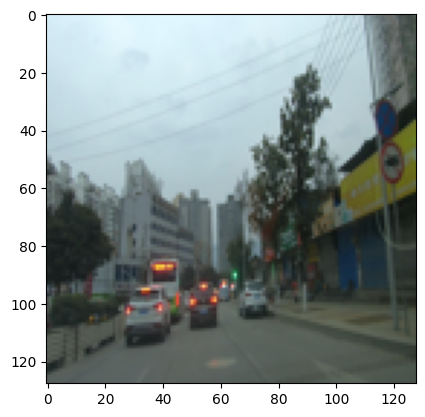

label: 1


In [50]:
# Display one of the images

i = 0
img = X_train_image[i]
plt.imshow(img)
plt.show()
print(f"label: {Y_reshaped[0][i]}")

In [51]:
# Assuming train_X and test_X are your input data variables
train_set_x = train_set_x.T  # Transpose to shape (1429, 12288)
cv_set_x = cv_set_x.T    # Transpose to shape (477, 12288)
test_set_x = test_set_x.T    # Transpose to shape (477, 12288)
Y_reshaped = Y_reshaped.T  # Transposing to shape (1429, 1)
y_cv_reshaped = y_cv_reshaped.T

In [52]:
print("train X shape: ", train_set_x.shape) # X_train: numpy array with shape: (num_samples_train, num_features)
print("train y shape: ", Y_reshaped.shape) # y_train: numpy array with shape: (num_samples_train,)
print("test X shape: ", cv_set_x.shape)   # X_test: numpy array with shape: (num_samples_test, num_features)
print("test y shape: ", y_cv_reshaped.shape)   # y_test: numpy array with shape: (num_samples_test,)

train X shape:  (1429, 49152)
train y shape:  (1429, 1)
test X shape:  (477, 49152)
test y shape:  (477, 1)


#### Build Model in Tensorflow

In [53]:
# build the model

# build the model

model = Sequential([
                    Dense(10, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │       491,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            44 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491,579 (1.88 MB)

 Trainable params: 491,579 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# compile the model

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

In [56]:
# fit the model

history = model.fit(train_set_x, Y_reshaped, epochs=20, batch_size=64, verbose=2, validation_split=0.2)

Epoch 1/20
18/18 - 2s - 96ms/step - binary_accuracy: 0.6264 - loss: 5.2996 - val_binary_accuracy: 0.7343 - val_loss: 0.6285
Epoch 2/20
18/18 - 0s - 17ms/step - binary_accuracy: 0.6964 - loss: 0.6210 - val_binary_accuracy: 0.7343 - val_loss: 0.5835
Epoch 3/20
18/18 - 0s - 16ms/step - binary_accuracy: 0.6964 - loss: 0.6140 - val_binary_accuracy: 0.7343 - val_loss: 0.5802
Epoch 4/20
18/18 - 0s - 14ms/step - binary_accuracy: 0.6964 - loss: 0.6146 - val_binary_accuracy: 0.7343 - val_loss: 0.5818
Epoch 5/20
18/18 - 0s - 16ms/step - binary_accuracy: 0.6964 - loss: 0.6141 - val_binary_accuracy: 0.7343 - val_loss: 0.5828
Epoch 6/20
18/18 - 0s - 14ms/step - binary_accuracy: 0.6964 - loss: 0.6140 - val_binary_accuracy: 0.7343 - val_loss: 0.5826
Epoch 7/20
18/18 - 0s - 19ms/step - binary_accuracy: 0.6964 - loss: 0.6140 - val_binary_accuracy: 0.7343 - val_loss: 0.5824
Epoch 8/20
18/18 - 0s - 15ms/step - binary_accuracy: 0.6964 - loss: 0.6140 - val_binary_accuracy: 0.7343 - val_loss: 0.5824
Epoch 9/

In [57]:
# Load the history into a pandas Dataframe

df = pd.DataFrame(history.history)

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

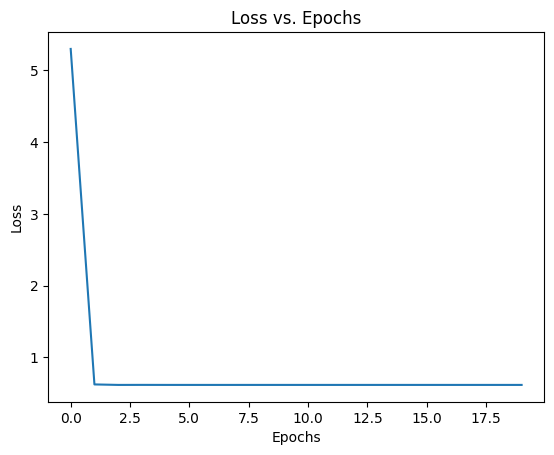

In [58]:
# Make a plot for the loss

loss_plot = df.plot(y="loss", title = "Loss vs. Epochs", legend=False)
loss_plot.set(xlabel="Epochs", ylabel="Loss")

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'binary_crossentropy')]

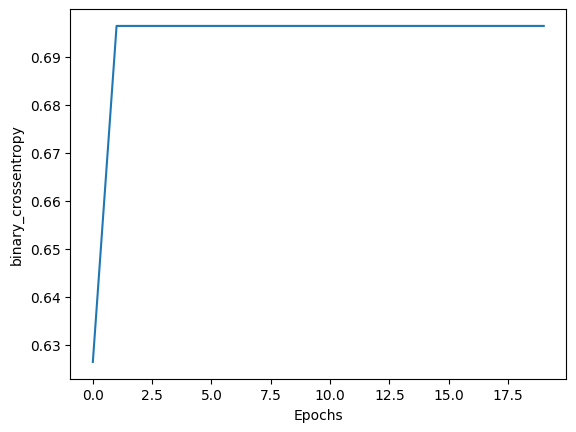

In [59]:
# Make a plot for the accuracy

accuracy_plot = df.plot(y="binary_accuracy", legend=False)
accuracy_plot.set(xlabel="Epochs", ylabel="binary_crossentropy")

In [60]:
# Model Evaluate on Test

model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - binary_accuracy: 0.7037 - loss: 0.6079


[0.6037746667861938, 0.7085953950881958]

label: [0]


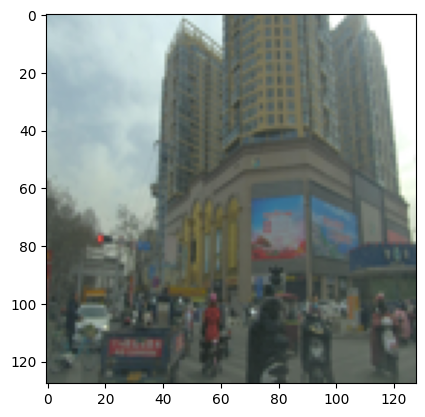

In [61]:
# Choose a random test image

random_inx = np.random.choice(cv_set_x.shape[0])

# Load the image file
plt.imshow(x_cv_image[random_inx])
print(f"label: {y_cv_reshaped[random_inx]}")

In [62]:
# Get the model predictions

X_sample = cv_set_x[random_inx][:]
X_sample = X_sample.reshape(1, -1) 
X_sample.shape

(1, 49152)

In [63]:
predictions = model.predict(X_sample)
print(f"Actual y value:{y_test[random_inx]}")
print(f"Model prediction:{np.argmax(predictions)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Actual y value:1
Model prediction:0


### B) Three Different Optimization Algorithms

#### 1. Adam

In [64]:
model1 = Sequential([
                    Dense(4, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
# compile the model

model1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [66]:
# fit the model with validation set

history1 = model1.fit(train_set_x, Y_reshaped, epochs = 20, batch_size = 64, verbose = 2, validation_split=0.25)

Epoch 1/20
17/17 - 1s - 75ms/step - binary_accuracy: 0.6190 - loss: 7.9921 - val_binary_accuracy: 0.7430 - val_loss: 0.6320
Epoch 2/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6323 - val_binary_accuracy: 0.7430 - val_loss: 0.5807
Epoch 3/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6196 - val_binary_accuracy: 0.7430 - val_loss: 0.5734
Epoch 4/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6187 - val_binary_accuracy: 0.7430 - val_loss: 0.5750
Epoch 5/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6185 - val_binary_accuracy: 0.7430 - val_loss: 0.5769
Epoch 6/20
17/17 - 0s - 12ms/step - binary_accuracy: 0.6909 - loss: 0.6188 - val_binary_accuracy: 0.7430 - val_loss: 0.5769
Epoch 7/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6188 - val_binary_accuracy: 0.7430 - val_loss: 0.5765
Epoch 8/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6188 - val_binary_accuracy: 0.7430 - val_loss: 0.5765
Epoch 9/

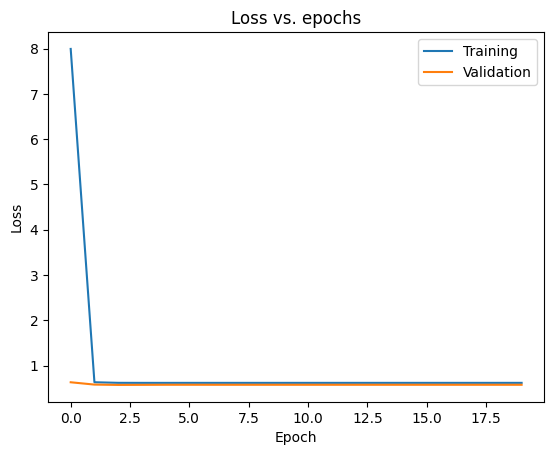

In [67]:
# Plot the training and validation loss

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [68]:
model1.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6857 - loss: 0.6226


[0.607856035232544, 0.703988790512085]

#### 2. RMSprop

In [69]:
model2 = Sequential([
                    Dense(4, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

In [70]:
# compile the model

model2.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.05),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [71]:
# fit the model with validation set

history2 = model2.fit(train_set_x, Y_reshaped, epochs = 20, batch_size = 64, verbose = 2, validation_split=0.25)

Epoch 1/20
17/17 - 1s - 56ms/step - binary_accuracy: 0.6909 - loss: 102.6717 - val_binary_accuracy: 0.7430 - val_loss: 0.5885
Epoch 2/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6203 - val_binary_accuracy: 0.7430 - val_loss: 0.5866
Epoch 3/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6203 - val_binary_accuracy: 0.7430 - val_loss: 0.5874
Epoch 4/20
17/17 - 0s - 15ms/step - binary_accuracy: 0.6909 - loss: 0.6204 - val_binary_accuracy: 0.7430 - val_loss: 0.5875
Epoch 5/20
17/17 - 0s - 13ms/step - binary_accuracy: 0.6909 - loss: 0.6204 - val_binary_accuracy: 0.7430 - val_loss: 0.5875
Epoch 6/20
17/17 - 0s - 14ms/step - binary_accuracy: 0.6909 - loss: 0.6204 - val_binary_accuracy: 0.7430 - val_loss: 0.5875
Epoch 7/20
17/17 - 0s - 14ms/step - binary_accuracy: 0.6909 - loss: 0.6204 - val_binary_accuracy: 0.7430 - val_loss: 0.5876
Epoch 8/20
17/17 - 0s - 14ms/step - binary_accuracy: 0.6909 - loss: 0.6204 - val_binary_accuracy: 0.7430 - val_loss: 0.5876
Epoch 

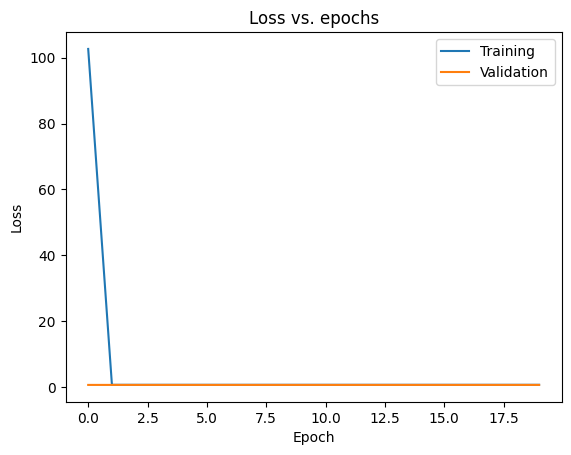

In [72]:
# Plot the training and validation loss

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [73]:
model2.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6857 - loss: 0.6244


[0.6125798225402832, 0.703988790512085]

#### 3. Gradient Descent (SGD)

In [74]:
#build a model with dropout regularizer

model3 = Sequential([
                    Dense(4, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(4, activation = 'relu', input_shape = (4,)),
                    Dense(1, activation = 'sigmoid')
])

In [75]:
# compile the model

model3.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.05),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [76]:
# fit the model with validation set

history3 = model3.fit(train_set_x, Y_reshaped, epochs = 20, batch_size = 64, verbose = 2, validation_split=0.25)

Epoch 1/20
17/17 - 1s - 34ms/step - binary_accuracy: 0.6611 - loss: 0.8410 - val_binary_accuracy: 0.7430 - val_loss: 0.6648
Epoch 2/20
17/17 - 0s - 11ms/step - binary_accuracy: 0.6909 - loss: 0.6626 - val_binary_accuracy: 0.7430 - val_loss: 0.6409
Epoch 3/20
17/17 - 0s - 11ms/step - binary_accuracy: 0.6909 - loss: 0.6480 - val_binary_accuracy: 0.7430 - val_loss: 0.6242
Epoch 4/20
17/17 - 0s - 11ms/step - binary_accuracy: 0.6909 - loss: 0.6384 - val_binary_accuracy: 0.7430 - val_loss: 0.6124
Epoch 5/20
17/17 - 0s - 11ms/step - binary_accuracy: 0.6909 - loss: 0.6320 - val_binary_accuracy: 0.7430 - val_loss: 0.6038
Epoch 6/20
17/17 - 0s - 12ms/step - binary_accuracy: 0.6909 - loss: 0.6277 - val_binary_accuracy: 0.7430 - val_loss: 0.5976
Epoch 7/20
17/17 - 0s - 11ms/step - binary_accuracy: 0.6909 - loss: 0.6248 - val_binary_accuracy: 0.7430 - val_loss: 0.5930
Epoch 8/20
17/17 - 0s - 12ms/step - binary_accuracy: 0.6909 - loss: 0.6229 - val_binary_accuracy: 0.7430 - val_loss: 0.5895
Epoch 9/

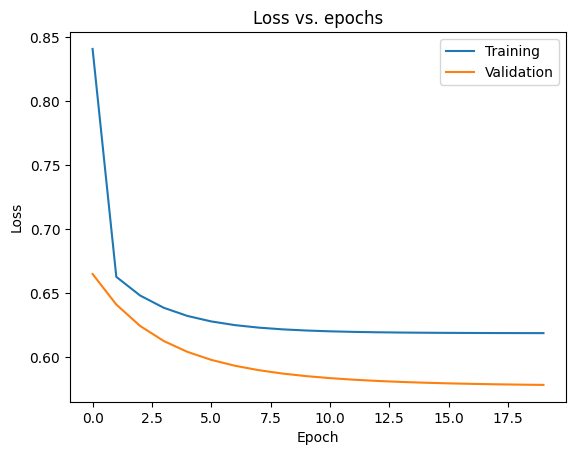

In [77]:
# Plot the training and validation loss

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [78]:
model3.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6857 - loss: 0.6225


[0.608299195766449, 0.703988790512085]

### C) Different Epochs

#### 1. Adam

In [79]:
# for a in [0.001, 0.005, 0.01, 0.05, 0.1]: 
#     for i in [20, 30, 40, 50, 60]: 
#         model1 = Sequential([
#                         Dense(4, activation = 'relu', input_shape = (train_set_x.shape[1],)),
#                         Dense(4, activation = 'relu', input_shape = (4,)),
#                         Dense(1, activation = 'sigmoid')
#         ])
#         model1.compile(
#             optimizer = tf.keras.optimizers.Adam(learning_rate = a),
#             loss = tf.keras.losses.BinaryCrossentropy(),
#             metrics = [tf.keras.metrics.BinaryAccuracy()]
#         )

#         history1 = model1.fit(train_set_x, Y_reshaped, epochs = i, batch_size = 64, verbose = 0, validation_split=0.25)
#         pred_train_1 = model1.evaluate(train_set_x,Y_reshaped)
#         pred_cv_1 = model1.evaluate(cv_set_x,y_cv_reshaped)
#         print("model1-Adam")
#         print(f"learning rate: {a}")
#         print(f"epoch: {i}")
#         plt.plot(history1.history['loss'])
#         plt.plot(history1.history['val_loss'])
#         plt.title('Loss vs. epochs')
#         plt.ylabel('Loss')
#         plt.xlabel('Epoch')
#         plt.legend(['Training', 'Validation'], loc='upper right')
#         plt.show()
#         print(f"train accuracy: {pred_train_1[1]}")
#         print(f"cv accuracy: {pred_cv_1[1]}\n")

#### 2. RMSprop

In [80]:
# for a in [0.001, 0.005, 0.01, 0.05, 0.1]: 
#     for i in [20, 30, 40, 50, 60]: 
#         model2 = Sequential([
#                     Dense(4, activation = 'relu', input_shape = (train_set_x.shape[1],)),
#                     Dense(4, activation = 'relu'),
#                     Dense(1, activation = 'sigmoid')
#                     ])
        
#         model2.compile(
#                         optimizer = tf.keras.optimizers.RMSprop(learning_rate = a),
#                         loss = tf.keras.losses.BinaryCrossentropy(),
#                         metrics = [tf.keras.metrics.BinaryAccuracy()]
#                         )

#         history2 = model2.fit(train_set_x, Y_reshaped, epochs = i, batch_size = 64, verbose = 0, validation_split=0.25)
#         pred_train_2 = model2.evaluate(train_set_x,Y_reshaped)
#         pred_cv_2 = model2.evaluate(cv_set_x,y_cv_reshaped)
#         print("model2-RMSprop")
#         print(f"learning rate: {a}")
#         print(f"epoch: {i}")
#         plt.plot(history2.history['loss'])
#         plt.plot(history2.history['val_loss'])
#         plt.title('Loss vs. epochs')
#         plt.ylabel('Loss')
#         plt.xlabel('Epoch')
#         plt.legend(['Training', 'Validation'], loc='upper right')
#         plt.show()
#         print(f"train accuracy: {pred_train_2[1]}")
#         print(f"cv accuracy: {pred_cv_2[1]}\n")

#### 3. Gradient Descent (SGD)

In [81]:
# for a in [0.001, 0.005, 0.01, 0.05, 0.1]: 
#     for i in [20, 30, 40, 50, 60]: 
#         model3 = Sequential([
#                     Dense(4, activation = 'relu', input_shape = (train_set_x.shape[1],)),
#                     Dense(4, activation = 'relu', input_shape = (4,)),
#                     Dense(1, activation = 'sigmoid')
#                     ])
        
#         model3.compile(
#                         optimizer = tf.keras.optimizers.SGD(learning_rate = 0.05),
#                         loss = tf.keras.losses.BinaryCrossentropy(),
#                         metrics = [tf.keras.metrics.BinaryAccuracy()]
#                         )

#         history3 = model3.fit(train_set_x, Y_reshaped, epochs = i, batch_size = 64, verbose = 0, validation_split=0.25)
#         pred_train_3 = model3.evaluate(train_set_x,Y_reshaped)
#         pred_cv_3 = model3.evaluate(cv_set_x,y_cv_reshaped)
#         print("model3-RMSprop")
#         print(f"learning rate: {a}")
#         print(f"epoch: {i}")
#         plt.plot(history2.history['loss'])
#         plt.plot(history2.history['val_loss'])
#         plt.title('Loss vs. epochs')
#         plt.ylabel('Loss')
#         plt.xlabel('Epoch')
#         plt.legend(['Training', 'Validation'], loc='upper right')
#         plt.show()
#         print(f"train accuracy: {pred_train_3[1]}")
#         print(f"cv accuracy: {pred_cv_3[1]}\n")

Experimenting with the Adam optimizer using a large number of epochs

In [82]:
# for i in [100,1000,10000]: 
#     model1 = Sequential([
#                     Dense(4, activation = 'relu', input_shape = (train_set_x.shape[1],)),
#                     Dense(4, activation = 'relu', input_shape = (4,)),
#                     Dense(1, activation = 'sigmoid')
#     ])
#     model1.compile(
#         optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
#         loss = tf.keras.losses.BinaryCrossentropy(),
#         metrics = [tf.keras.metrics.BinaryAccuracy()]
#     )

#     history1 = model1.fit(train_set_x, Y_reshaped, epochs = i, batch_size = 64, verbose = 0, validation_split=0.25)
#     pred_train_1 = model1.evaluate(train_set_x,Y_reshaped)
#     pred_cv_1 = model1.evaluate(cv_set_x,y_cv_reshaped)
#     print("model1-Adam")
#     print(f"learning rate: {a}")
#     print(f"epoch: {i}")
#     plt.plot(history1.history['loss'])
#     plt.plot(history1.history['val_loss'])
#     plt.title('Loss vs. epochs')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Training', 'Validation'], loc='upper right')
#     plt.show()
#     print(f"train accuracy: {pred_train_1[1]}")
#     print(f"cv accuracy: {pred_cv_1[1]}\n")

In [351]:
for e in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: 
    for b in [25, 50 , 75, 100, 125]: 
        model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                    ])
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics = [tf.keras.metrics.BinaryAccuracy()]
        )

        history = model.fit(train_set_x, Y_reshaped, epochs = e, batch_size = b, verbose = False, validation_split=0.25)

        pred_train = model.evaluate(train_set_x,Y_reshaped)
        pred_cv = model.evaluate(cv_set_x,y_cv_reshaped)
        
        print(f"epoch: {e}")
        print(f"batch size: {b}")
        print(f"train: {pred_train}")
        print(f"cv: {pred_cv}\n")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6506
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6455 
epoch: 10
batch size: 25
train: [0.645389199256897, 0.703988790512085]
cv: [0.6440854668617249, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6268
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6272 
epoch: 10
batch size: 50
train: [0.6201752424240112, 0.703988790512085]
cv: [0.6219369173049927, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6735
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6715 
epoch: 10
batch size: 75
train: [0.6714155673980713, 0.703988790512085]
cv: [0.67088782787323, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6754
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6736 
epoch

In [352]:
for e in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: 
    for b in [25, 50 , 75, 100, 125]: 
        model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                    ])
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics = [tf.keras.metrics.BinaryAccuracy()]
        )

        history = model.fit(train_set_x, Y_reshaped, epochs = e, batch_size = b, verbose = False, validation_split=0.25)

        pred_train = model.evaluate(train_set_x,Y_reshaped)
        pred_cv = model.evaluate(cv_set_x,y_cv_reshaped)
        
        print(f"epoch: {e}")
        print(f"batch size: {b}")
        print(f"train: {pred_train}")
        print(f"cv: {pred_cv}\n")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6122
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6131 
epoch: 10
batch size: 25
train: [0.603379487991333, 0.703988790512085]
cv: [0.6066870093345642, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6245
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6128 
epoch: 10
batch size: 50
train: [0.6126356720924377, 0.703988790512085]
cv: [0.6096581816673279, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6420
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6354 
epoch: 10
batch size: 75
train: [0.635292112827301, 0.703988790512085]
cv: [0.633612334728241, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6543
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6498 
epoch

In [353]:
for e in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: 
    for b in [25, 50 , 75, 100, 125]: 
        model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                    ])
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics = [tf.keras.metrics.BinaryAccuracy()]
        )

        history = model.fit(train_set_x, Y_reshaped, epochs = e, batch_size = b, verbose = False, validation_split=0.25)

        pred_train = model.evaluate(train_set_x,Y_reshaped)
        pred_cv = model.evaluate(cv_set_x,y_cv_reshaped)
        
        print(f"epoch: {e}")
        print(f"batch size: {b}")
        print(f"train: {pred_train}")
        print(f"cv: {pred_cv}\n")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6857 - loss: 0.6226
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6081 
epoch: 10
batch size: 25
train: [0.6078618764877319, 0.703988790512085]
cv: [0.604160487651825, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6968 - loss: 0.5966
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6514 - loss: 0.6334 
epoch: 10
batch size: 50
train: [0.5983458161354065, 0.7053883671760559]
cv: [0.6239112615585327, 0.6708595156669617]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6225
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6086 
epoch: 10
batch size: 75
train: [0.6083039045333862, 0.703988790512085]
cv: [0.6047283411026001, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6857 - loss: 0.6257
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6147
epo

In [354]:
for e in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: 
    for b in [25, 50 , 75, 100, 125]: 
        model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                    ])
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics = [tf.keras.metrics.BinaryAccuracy()]
        )

        history = model.fit(train_set_x, Y_reshaped, epochs = e, batch_size = b, verbose = False, validation_split=0.25)

        pred_train = model.evaluate(train_set_x,Y_reshaped)
        pred_cv = model.evaluate(cv_set_x,y_cv_reshaped)
        
        print(f"epoch: {e}")
        print(f"batch size: {b}")
        print(f"train: {pred_train}")
        print(f"cv: {pred_cv}\n")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6225
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6084
epoch: 10
batch size: 25
train: [0.6081861853599548, 0.703988790512085]
cv: [0.6045812368392944, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6226
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6082 
epoch: 10
batch size: 50
train: [0.6078986525535583, 0.703988790512085]
cv: [0.6042097210884094, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6225
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6084
epoch: 10
batch size: 75
train: [0.608184814453125, 0.703988790512085]
cv: [0.6045793890953064, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6225
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6083 
epoch

In [355]:
for e in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]: 
    for b in [25, 50 , 75, 100, 125]: 
        model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
                    ])
        
        model.compile(
            optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics = [tf.keras.metrics.BinaryAccuracy()]
        )

        history = model.fit(train_set_x, Y_reshaped, epochs = e, batch_size = b, verbose = False, validation_split=0.25)

        pred_train = model.evaluate(train_set_x,Y_reshaped)
        pred_cv = model.evaluate(cv_set_x,y_cv_reshaped)
        
        print(f"epoch: {e}")
        print(f"batch size: {b}")
        print(f"train: {pred_train}")
        print(f"cv: {pred_cv}\n")

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6239
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6118 
epoch: 10
batch size: 25
train: [0.6116182804107666, 0.703988790512085]
cv: [0.6085373759269714, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6226
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6081 
epoch: 10
batch size: 50
train: [0.6078685522079468, 0.703988790512085]
cv: [0.6041695475578308, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6857 - loss: 0.6225
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6084 
epoch: 10
batch size: 75
train: [0.6081476807594299, 0.703988790512085]
cv: [0.6045325398445129, 0.7085953950881958]

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6857 - loss: 0.6225
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7037 - loss: 0.6082 
ep

### 1. Use TensorFlow to improve validation performance

#### a. Changing the structure of your NN model

In [420]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

In [421]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [425]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [426]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8723 - loss: 0.3218


[0.4542447030544281, 0.8026592135429382]

In [427]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.5285 - loss: 0.9821 


[0.9177438616752625, 0.5387840867042542]

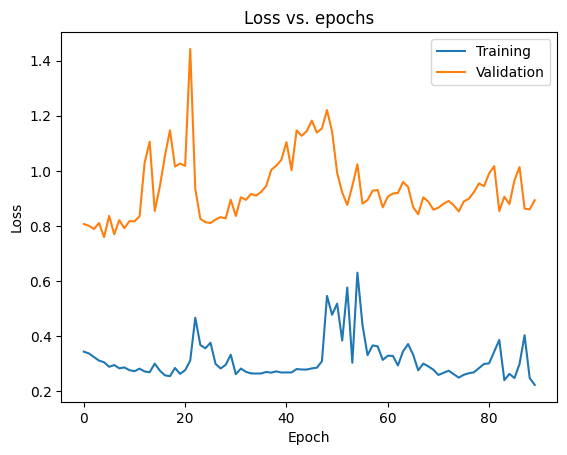

In [428]:
#Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

#### b. Implement L2 regularization

In [429]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(8, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(4, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                    Dense(1, activation = 'sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

In [430]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [434]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [435]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6807


[0.6702772378921509, 0.703988790512085]

In [436]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6704


[0.667626678943634, 0.7085953950881958]

#### c. Implement Dropout Regularization

In [208]:
from tensorflow.keras.layers import Dropout

In [443]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(train_set_x.shape[1],)),
    Dropout(0.25),  # Dropout 20% of the neurons
    Dense(8, activation='relu'),
    Dropout(0.25),  # Another dropout layer
    Dense(4, activation='relu'),
    Dropout(0.25),  # Another dropout layer
    Dense(1, activation='sigmoid')
])

In [444]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [450]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [451]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6225


[0.6081845760345459, 0.703988790512085]

In [452]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7037 - loss: 0.6084


[0.6045789122581482, 0.7085953950881958]

#### d. Implement Early Stopping

In [453]:
from tensorflow.keras.callbacks import EarlyStopping

In [454]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

In [455]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [472]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10) 

In [473]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25,
                    callbacks=[early_stopping])

In [474]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6225


[0.6080636382102966, 0.703988790512085]

In [475]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.7037 - loss: 0.6083


[0.6044255495071411, 0.7085953950881958]

### 2. Improve training performance using a better weight initialization

#### Combination 1 - random_uniform w/ bias: zeros

In [542]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_initializer='random_uniform', bias_initializer='zeros'),
                    Dense(8, activation = 'relu', kernel_initializer='random_uniform', bias_initializer='zeros'),
                    Dense(4, activation = 'relu', kernel_initializer='random_uniform', bias_initializer='zeros'),
                    Dense(1, activation = 'sigmoid')
])

In [543]:
model.summary()

Model: "sequential_335"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1307 (Dense)              │ (None, 16)             │       786,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1308 (Dense)              │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1309 (Dense)              │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1310 (Dense)              │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,625 (3.00 MB)

 Trainable params: 786,625 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [544]:
model.weights

[<KerasVariable shape=(49152, 16), dtype=float32, path=sequential_335/dense_1307/kernel>,
 <KerasVariable shape=(16,), dtype=float32, path=sequential_335/dense_1307/bias>,
 <KerasVariable shape=(16, 8), dtype=float32, path=sequential_335/dense_1308/kernel>,
 <KerasVariable shape=(8,), dtype=float32, path=sequential_335/dense_1308/bias>,
 <KerasVariable shape=(8, 4), dtype=float32, path=sequential_335/dense_1309/kernel>,
 <KerasVariable shape=(4,), dtype=float32, path=sequential_335/dense_1309/bias>,
 <KerasVariable shape=(4, 1), dtype=float32, path=sequential_335/dense_1310/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential_335/dense_1310/bias>]

In [545]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [552]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [553]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8899 - loss: 0.2791


[0.564589262008667, 0.8166549801826477]

In [554]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.5590 - loss: 1.5739


[1.444608211517334, 0.5555555820465088]

#### Combination 2 - random_normal w/ bias: zeros

In [560]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_initializer='random_normal', bias_initializer='zeros'),
                    Dense(8, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
                    Dense(4, activation = 'relu', kernel_initializer='random_normal', bias_initializer='zeros'),
                    Dense(1, activation = 'sigmoid')
])

In [561]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [562]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [563]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6857 - loss: 0.6225


[0.6080560088157654, 0.703988790512085]

In [564]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.7037 - loss: 0.6083


[0.6044154763221741, 0.7085953950881958]

#### Combination 3 - random_uniform w/ bias: ones

In [570]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_initializer='random_uniform', bias_initializer='ones'),
                    Dense(8, activation = 'relu', kernel_initializer='random_uniform', bias_initializer='ones'),
                    Dense(4, activation = 'relu', kernel_initializer='random_uniform', bias_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

In [571]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [572]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [573]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8620 - loss: 0.3194


[0.4161521792411804, 0.830650806427002]

In [574]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.6840 - loss: 0.9178 


[0.8586171865463257, 0.6834381818771362]

#### Combination 4 - random_normal w/ bias = ones

In [575]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_initializer='random_normal', bias_initializer='ones'),
                    Dense(8, activation = 'relu', kernel_initializer='random_normal', bias_initializer='ones'),
                    Dense(4, activation = 'relu', kernel_initializer='random_normal', bias_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

In [576]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [577]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [578]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6226


[0.6087528467178345, 0.703988790512085]

In [579]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6090


[0.6052740216255188, 0.7085953950881958]

#### Combination 5 - he_uniform w/ bias = zeros

In [580]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_initializer='he_uniform', bias_initializer='zeros'),
                    Dense(8, activation = 'relu', kernel_initializer='he_uniform', bias_initializer='zeros'),
                    Dense(4, activation = 'relu', kernel_initializer='he_uniform', bias_initializer='zeros'),
                    Dense(1, activation = 'sigmoid')
])

In [581]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [582]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [583]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6857 - loss: 0.6225


[0.6085086464881897, 0.703988790512085]

In [584]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6088 


[0.6049796938896179, 0.7085953950881958]

#### Combination 6 - he_uniform w/ bias = ones

In [585]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_initializer='he_uniform', bias_initializer='ones'),
                    Dense(8, activation = 'relu', kernel_initializer='he_uniform', bias_initializer='ones'),
                    Dense(4, activation = 'relu', kernel_initializer='he_uniform', bias_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [586]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [587]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [588]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6857 - loss: 0.6225


[0.6080355644226074, 0.703988790512085]

In [589]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6083


[0.6043894290924072, 0.7085953950881958]

#### Combination 7 - he_normal w/ bias = zeros

In [590]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_initializer='he_normal', bias_initializer='zeros'),
                    Dense(8, activation = 'relu', kernel_initializer='he_normal', bias_initializer='zeros'),
                    Dense(4, activation = 'relu', kernel_initializer='he_normal', bias_initializer='zeros'),
                    Dense(1, activation = 'sigmoid')
])

In [591]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [592]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [593]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6857 - loss: 0.6225


[0.6084747910499573, 0.703988790512085]

In [594]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - binary_accuracy: 0.7037 - loss: 0.6087


[0.6049383878707886, 0.7085953950881958]

#### Combination 8 - he_normal w/ bias = ones

In [595]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],), kernel_initializer='he_normal', bias_initializer='ones'),
                    Dense(8, activation = 'relu', kernel_initializer='he_normal', bias_initializer='ones'),
                    Dense(4, activation = 'relu', kernel_initializer='he_normal', bias_initializer='ones'),
                    Dense(1, activation = 'sigmoid')
])

In [596]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

In [597]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [598]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6857 - loss: 0.6225


[0.6080390810966492, 0.703988790512085]

In [599]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.7037 - loss: 0.6083


[0.6043938994407654, 0.7085953950881958]

### 3. Use the TensorFlow to improve validation performance using batch-normalization

In [628]:
from tensorflow.keras.layers import BatchNormalization, Activation

def build_model(m=0.99, e=0.001, s=True, c=True):
    model = Sequential([
        Dense(16, input_shape=(input_shape,)),
        BatchNormalization(momentum=m, epsilon=e, scale=s, center=c),
        Activation('relu'),
        Dense(8),
        BatchNormalization(momentum=m, epsilon=e, scale=s, center=c),
        Activation('relu'),
        Dense(4),
        BatchNormalization(momentum=m, epsilon=e, scale=s, center=c),
        Activation('relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
           )

    return model

#### Combination 1 - Default

In [629]:
input_shape = train_set_x.shape[1]
model = build_model()
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [630]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.9846 - loss: 0.0656


[0.32776036858558655, 0.9174247980117798]

In [631]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.6239 - loss: 1.4944


[1.4463510513305664, 0.6268343925476074]

#### Combination 2 - m=0.90, e=0.001, s=True, c=True

In [632]:
input_shape = train_set_x.shape[1]
model = build_model(m=0.90, e=0.001, s=True, c=True)
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [633]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9859 - loss: 0.0620


[0.33014997839927673, 0.9160252213478088]

In [634]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6398 - loss: 1.4800


[1.4359709024429321, 0.6352201104164124]

#### Combination 3 - m=0.65, e=0.001, s=True, c=True

In [635]:
input_shape = train_set_x.shape[1]
model = build_model(m=0.65, e=0.001, s=True, c=True)
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [636]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7991 - loss: 0.8902


[1.0859375, 0.7732680439949036]

In [637]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6831 - loss: 1.8934 


[1.8788697719573975, 0.6855345964431763]

#### Combination 4 - m=0.99, e=0.001, s=False, c=False

In [644]:
input_shape = train_set_x.shape[1]
model = build_model(m=0.99, e=0.001, s=False, c=False)
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [642]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9372 - loss: 0.1927


[0.36226367950439453, 0.852344274520874]

In [643]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.5605 - loss: 0.9012


[0.8626807332038879, 0.5786163806915283]

#### Combination 5 - m=0.50, e=0.001, s=True, c=False

In [645]:
input_shape = train_set_x.shape[1]
model = build_model(m=0.50, e=0.001, s=True, c=False)
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [646]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9811 - loss: 0.0944


[0.2797793447971344, 0.9118264317512512]

In [647]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_accuracy: 0.6525 - loss: 0.9684


[0.9607721567153931, 0.6582809090614319]

#### Combination 6 - m=0.10, e=0.001, s=True, c=True

In [659]:
input_shape = train_set_x.shape[1]
model = build_model(m=0.1)
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [660]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.9629 - loss: 0.1018


[0.33324941992759705, 0.8992302417755127]

In [661]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - binary_accuracy: 0.6317 - loss: 1.4161 


[1.3916140794754028, 0.6310272812843323]

### 4. Which metric(s) are you using to evaluate the performance of your model.

In [663]:
model = Sequential([
                    Dense(16, activation = 'relu', input_shape = (train_set_x.shape[1],)),
                    Dense(8, activation = 'relu'),
                    Dense(4, activation = 'relu'),
                    Dense(1, activation = 'sigmoid')
])

In [664]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall')]
)


In [665]:
history = model.fit(train_set_x, Y_reshaped, epochs = 90, batch_size = 50, verbose = False, validation_split=0.25)

In [666]:
model.evaluate(train_set_x,Y_reshaped)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6857 - loss: 0.6225 - precision: 0.6857 - recall: 1.0000


[0.6080900430679321, 0.703988790512085, 0.703988790512085, 1.0]

In [667]:
model.evaluate(cv_set_x,y_cv_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7037 - loss: 0.6083 - precision: 0.7037 - recall: 1.0000


[0.6044592261314392, 0.7085953950881958, 0.7085953950881958, 1.0]